# Data & Results

get Aarronson replication data to work from https://www.aeaweb.org/articles?id=10.1257/pol.20190414

## Import Maps & RL Data

In [1]:
import os
import geopandas as gpd
import pandas as pd

# Fix PROJ path if needed (for coordinate transforms)
os.environ["PROJ_LIB"] = "/home/idies/mambaforge/envs/econark/share/proj"

# === 1. Load HOLC data ===
holc = gpd.read_file("mappinginequality.gpkg")

# === 2. Filter for Chicago ===
holc_chi = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
print(f"HOLC polygons loaded for Chicago: {len(holc_chi)}")

# Keep relevant columns
holc_chi = holc_chi[["area_id", "grade", "geometry"]]

# Display a preview table
display(holc_chi.head())

# === 3. Ensure coordinate system is projected in meters ===
# This step is required for buffer distances
holc_chi = holc_chi.to_crs(epsg=26916)  # NAD83 / UTM zone 16N (covers Chicago region)

# === 4. Create 0.25-mile (≈402 meters) buffers around each HOLC boundary ===
buffer_distance = 402  # meters
holc_buffers = holc_chi.copy()
holc_buffers["geometry"] = holc_buffers.buffer(buffer_distance)

print(f"Created buffer zones of {buffer_distance} meters around each HOLC area.")

# Preview buffers (optional)
display(holc_buffers.head())

# === 5. (Optional) Save buffers for reference ===
holc_buffers.to_file("holc_chicago_buffers.geojson", driver="GeoJSON")


ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


HOLC polygons loaded for Chicago: 703


,area_id,grade,geometry
2014,11474,C,"POLYGON ((-87.86999 41.8197, -87.87006 41.8233..."
2015,1065,A,"MULTIPOLYGON (((-87.83054 42.25361, -87.82979 ..."
2016,1091,A,"MULTIPOLYGON (((-87.76217 42.12934, -87.76233 ..."
2017,1097,A,"MULTIPOLYGON (((-87.75082 42.13867, -87.75053 ..."
2018,1098,A,"MULTIPOLYGON (((-87.74436 42.12695, -87.74135 ..."


Created buffer zones of 402 meters around each HOLC area.


,area_id,grade,geometry
2014,11474,C,"POLYGON ((426501.391 4631102.169, 426501.357 4..."
2015,1065,A,"POLYGON ((430989.571 4678536.142, 430973.129 4..."
2016,1091,A,"POLYGON ((436051.194 4664575.432, 436017.698 4..."
2017,1097,A,"POLYGON ((437691.579 4665139.54, 437664.869 46..."
2018,1098,A,"POLYGON ((437876.497 4664646.627, 437715.765 4..."


### Table 1
- There are 703 mapped areas (neighborhood polygons) in Chicago that were graded by the Home Owners’ Loan Corporation (HOLC) in the 1930s.
- Each of these polygons corresponds to a distinct neighborhood “area” on the redlining map.

### Table 2
- created 0.25-mile buffer polygons (≈402 meters) around each HOLC area.
- The geometry numbers are now in meters, not degrees**,** because we switched to a projected coordinate system — this allows accurate measurement of distances like “0.25 miles.”

## Import School Data

In [2]:
import pandas as pd

# === 1. Load both files ===
locations = pd.read_csv("school-locations.csv", dtype=str)
school_info = pd.read_csv("school-level.csv", dtype=str)

# === 2. Merge on NCESSCH (the unique school code) ===
merged = locations.merge(school_info, on="NCESSCH", how="inner")

# === 3. Filter for Chicago high schools ===
# Check column names that describe school type (they vary by dataset)
# Common ones include "LEVEL", "SCH_LEVEL", or "SCHOOL_TYPE"
# You can inspect available columns with:
# print(merged.columns)

# Example: assuming the column indicating school level is "LEVEL"
# and that high schools are labeled "High" or contain the word "High"
merged_chi = merged[
    (merged["CITY"].str.contains("Chicago", case=False, na=False)) &
    (merged["SCH_TYPE"].str.contains("1", case=False, na=False))
].copy()

# === 4. Keep relevant columns ===
cols_to_keep = ["NCESSCH", "NAME", "LAT", "LON", "CITY", "STATE"]
merged_chi = merged_chi[cols_to_keep]

# === 5. Convert coordinates to numeric (for mapping / GeoDataFrame use later) ===
merged_chi["LAT"] = merged_chi["LAT"].astype(float)
merged_chi["LON"] = merged_chi["LON"].astype(float)


# === 6. Display the resulting table ===
print("\n=== Chicago High Schools with Coordinates ===")
print(merged_chi.head(20).to_string(index=False))

# === 7. (Optional) Save to CSV for use in GIS or later analysis ===
merged_chi.to_csv("chicago_high_schools_with_coords.csv", index=False)


=== Chicago High Schools with Coordinates ===
     NCESSCH                              NAME       LAT        LON            CITY STATE
170011004813         Neal Math Science Academy 42.324000 -87.855350   North Chicago    IL
170011004814           A J Katzenmaier Academy 42.326049 -87.862726   North Chicago    IL
170011004815           Evelyn Alexander School 42.337313 -87.840019   North Chicago    IL
170011005370  North Chicago Community High Sch 42.328032 -87.853182   North Chicago    IL
170011006357  Green Bay Early Childhood Center 42.320900 -87.868603   North Chicago    IL
170011006401           LEARN 10 Charter School 42.315417 -87.853826   North Chicago    IL
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.682103         Chicago    IL
170141206309      Horizon Science Acad-Belmont 41.925459 -87.770026         Chicago    IL
170142406394 Betty Shabazz Internl Charter Sch 41.752403 -87.599982         Chicago    IL
170142406396         Barbara A Sizemore Campus 41.775

## Chicago Schools in HOLC Boundary

In [3]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Load HOLC polygons and buffers ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=26916)  # UTM zone 16N

holc_buffers = gpd.read_file("holc_chicago_buffers.geojson").to_crs(epsg=26916)

# === 2. Load school location data ===
school_locations = pd.read_csv("school-locations.csv", dtype=str)
school_locations["LAT"] = school_locations["LAT"].astype(float)
school_locations["LON"] = school_locations["LON"].astype(float)

# Convert to GeoDataFrame
schools_gdf = gpd.GeoDataFrame(
    school_locations,
    geometry=gpd.points_from_xy(school_locations["LON"], school_locations["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=26916)

# === 3. Filter for Chicago high schools only ===
schools_chi = schools_gdf[schools_gdf["CITY"].str.contains("Chicago", case=False, na=False)].copy()
mask_exclude = schools_chi["NAME"].str.contains("elem|elementary|middle", case=False, na=False)
schools_chi = schools_chi[~mask_exclude].copy()
print(f"High schools in Chicago: {len(schools_chi)}")

# === 4. Assign actual HOLC district the school is in ===
schools_in_holc = gpd.sjoin(schools_chi, holc[["area_id", "grade", "geometry"]], how="left", predicate="within")

# Drop duplicates in case a school overlaps multiple polygons (should be rare)
schools_in_holc = schools_in_holc.drop_duplicates(subset="NCESSCH")

# === 5. Count number of HOLC buffer zones each school overlaps (optional) ===
overlap_counts = gpd.sjoin(schools_chi, holc_buffers, how="inner", predicate="intersects")
zone_count = overlap_counts.groupby("NCESSCH").size().reset_index(name="zone_count")

# === 6. Merge actual HOLC info with buffer overlap count ===
schools_combined = schools_in_holc.merge(zone_count, on="NCESSCH", how="left")
schools_combined["zone_count"] = schools_combined["zone_count"].fillna(0).astype(int)

# === 7. Drop schools with no HOLC grade ===
schools_combined = schools_combined[schools_combined["grade"].notna()].copy()
print(f"High schools with HOLC grade info: {len(schools_combined)}")

# === 8. Keep relevant columns ===
schools_combined = schools_combined[[
    "NCESSCH", "NAME", "LAT", "LON", "grade"
]]

# === 9. Preview results ===
print("\n=== Preview of combined results ===")
print(schools_combined.head(10).to_string(index=False))

# === 10. Save to CSV if needed ===
#output_file = "Chicago_HS_RL.csv"
#schools_combined.to_csv(output_file, index=False)
#print(f"✅ Cleaned table saved to: {os.path.abspath(output_file)}")


High schools in Chicago: 262
High schools with HOLC grade info: 159

=== Preview of combined results ===
     NCESSCH                              NAME       LAT        LON grade
170000603793                       IYC Chicago 41.884126 -87.687997     D
170009805220      IL Center for Rehab & Educ-R 41.867200 -87.675500     D
170141206309      Horizon Science Acad-Belmont 41.925459 -87.770026     C
170142406394 Betty Shabazz Internl Charter Sch 41.752403 -87.599982     C
170142406396         Barbara A Sizemore Campus 41.775011 -87.634407     D
170142606424        ACE Amandla Charter School 41.769223 -87.690965     C
170143106434   Bronzeville Academy Charter Sch 41.805200 -87.606919     D
170143606756  Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D
170993000588  Dunbar Vocational Career Acad HS 41.839600 -87.618700     D
170993000612        Mosaic School of Fine Arts 42.003600 -87.697900     B


## Import Calculus Data

In [4]:
import os
import pandas as pd

# === 1. Load your existing redline-filtered Chicago high schools ===
holc_schools_file = "Chicago_HS_RL.csv"
holc_schools = pd.read_csv(holc_schools_file, dtype=str)

print(f"HOLC-filtered schools loaded: {len(holc_schools)}")

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
print(f"Calculus dataset loaded: {len(calc)} rows")

# Convert numeric column safely
calc["SCH_MATHCLASSES_CALC"] = pd.to_numeric(calc["SCH_MATHCLASSES_CALC"], errors="coerce")

# === 3. Filter for valid (non-negative) calculus values ===
calc = calc[calc["SCH_MATHCLASSES_CALC"] >= 0].copy()
print(f"Schools with valid calculus data: {len(calc)}")

# === 4. Merge by NCES ID (COMBOKEY ↔ NCESSCH) ===
merged = holc_schools.merge(
    calc[["COMBOKEY", "SCH_NAME", "SCH_MATHCLASSES_CALC"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

print(f"Merged overlapping schools: {len(merged)}")

# === 5. Create indicator columns ===
merged["SCH_MATHCLASSES_CALC"] = merged["SCH_MATHCLASSES_CALC"].astype(int)
merged["Has_Calc"] = merged["SCH_MATHCLASSES_CALC"].apply(lambda x: "Yes" if x > 0 else "No")
merged["Num_Calc_Classes"] = merged["SCH_MATHCLASSES_CALC"]

# === 6. Keep relevant columns ===
calc_summary = merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade",  
    "Has_Calc", "Num_Calc_Classes"
]]

# === 7. Save to CSV ===
#output_file = "Calc_HS_Chicago.csv"
#calc_summary.to_csv(output_file, index=False)
#print(f"✅ Combined table saved to: {os.path.abspath(output_file)}")

# === 8. Preview first few rows ===
print("\n=== Preview of Calculus-overlapping schools ===")
print(calc_summary.head(10).to_string(index=False))


HOLC-filtered schools loaded: 159
Calculus dataset loaded: 97575 rows
Schools with valid calculus data: 26331
Merged overlapping schools: 111

=== Preview of Calculus-overlapping schools ===
     NCESSCH                             NAME       LAT        LON grade Has_Calc  Num_Calc_Classes
170000603793                      IYC Chicago 41.884126 -87.687997     D       No                 0
170142606424       ACE Amandla Charter School 41.769223 -87.690965     C       No                 0
170143606756 Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D       No                 0
170993000588 Dunbar Vocational Career Acad HS   41.8396   -87.6187     D       No                 0
170993000714         Young Magnet High School   41.8783   -87.6637     D      Yes                 8
170993000718       Richards Career Academy HS   41.8028   -87.6621     D       No                 0
170993000722      Juarez Community Academy HS 41.852914  -87.66456     D       No                 0
170993000

## Import CS Data

In [5]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

csci_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Computer Science.csv")
csci = pd.read_csv(csci_path, dtype=str)

csci["SCH_COMPCLASSES_CSCI"] = pd.to_numeric(csci["SCH_COMPCLASSES_CSCI"], errors="coerce")
csci = csci[csci["SCH_COMPCLASSES_CSCI"] >= 0].copy()

csci_merged = holc_schools.merge(
    csci[["COMBOKEY", "SCH_NAME", "SCH_COMPCLASSES_CSCI"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

csci_merged["SCH_COMPCLASSES_CSCI"] = csci_merged["SCH_COMPCLASSES_CSCI"].astype(int)
csci_merged["Has_CS"] = csci_merged["SCH_COMPCLASSES_CSCI"].apply(lambda x: "Yes" if x > 0 else "No")
csci_merged["Num_CS_Classes"] = csci_merged["SCH_COMPCLASSES_CSCI"]

csci_final = csci_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "Has_CS", "Num_CS_Classes"
]]

#output_file = "CS_HS_Chicago.csv"
#csci_final.to_csv(output_file, index=False)
#print(f"✅ Computer Science CSV saved to: {os.path.abspath(output_file)}")


## Import Physics Data

In [6]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

phys_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Physics.csv")
phys = pd.read_csv(phys_path, dtype=str)

phys["SCH_SCICLASSES_PHYS"] = pd.to_numeric(phys["SCH_SCICLASSES_PHYS"], errors="coerce")
phys = phys[phys["SCH_SCICLASSES_PHYS"] >= 0].copy()

phys_merged = holc_schools.merge(
    phys[["COMBOKEY", "SCH_NAME", "SCH_SCICLASSES_PHYS"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

phys_merged["SCH_SCICLASSES_PHYS"] = phys_merged["SCH_SCICLASSES_PHYS"].astype(int)
phys_merged["Has_Physics"] = phys_merged["SCH_SCICLASSES_PHYS"].apply(lambda x: "Yes" if x > 0 else "No")
phys_merged["Num_Physics_Classes"] = phys_merged["SCH_SCICLASSES_PHYS"]

phys_final = phys_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Physics", "Num_Physics_Classes"
]]

#output_file = "Phys_HS_Chicago.csv"
#phys_final.to_csv(output_file, index=False)
#print(f"✅ Physics CSV saved to: {os.path.abspath(output_file)}")


## Merge Datasets

In [7]:
import pandas as pd

calc = pd.read_csv("Calc_HS_Chicago.csv", dtype=str)
csci = pd.read_csv("CS_HS_Chicago.csv", dtype=str)
phys = pd.read_csv("Phys_HS_Chicago.csv", dtype=str)

# Merge sequentially on NCESSCH
combined = calc.merge(csci[["NCESSCH", "Has_CS", "Num_CS_Classes"]], on="NCESSCH", how="outer")
combined = combined.merge(phys[["NCESSCH", "Has_Physics", "Num_Physics_Classes"]], on="NCESSCH", how="outer")

# Replace NaNs with "No" or 0
combined["Has_Calc"] = combined["Has_Calc"].fillna("No")
combined["Has_CS"] = combined["Has_CS"].fillna("No")
combined["Has_Physics"] = combined["Has_Physics"].fillna("No")

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    combined[col] = pd.to_numeric(combined[col], errors="coerce").fillna(0).astype(int)

# Save merged CSV
#output_file = "All_Classes_HS_Chicago.csv"
#combined.to_csv(output_file, index=False)
#print(f"✅ All class data merged and saved to: {output_file}")

print("\n=== Preview of combined table ===")
print(combined.head(10).to_string(index=False))



=== Preview of combined table ===
     NCESSCH                             NAME       LAT        LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
170000603793                      IYC Chicago 41.884126 -87.687997     D       No                 0     No               0          No                    0
170142606424       ACE Amandla Charter School 41.769223 -87.690965     C       No                 0     No               0         Yes                    2
170143606756 Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D       No                 0     No               0         Yes                    2
170993000588 Dunbar Vocational Career Acad HS   41.8396   -87.6187     D       No                 0     No               0         Yes                    5
170993000714         Young Magnet High School   41.8783   -87.6637     D      Yes                 8    Yes              23         Yes                   34
170993000718       Richards C

## Data Visualization

### % Bar Chart

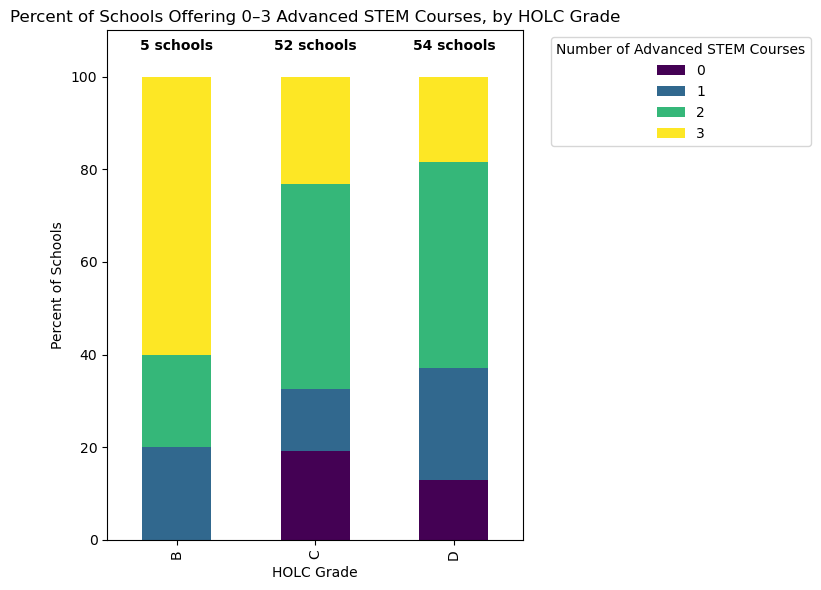

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade ===
Course_Profile  Total_Schools   0  0_pct   1  1_pct   2  2_pct   3  3_pct
grade                                                                    
B                           5   0    0.0   1   20.0   1   20.0   3   60.0
C                          52  10   19.2   7   13.5  23   44.2  12   23.1
D                          54   7   13.0  13   24.1  24   44.4  10   18.5


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("All_Classes_HS_Chicago.csv") 

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")

### Notes on % Bar Chart
- there are a few charter and magnet schools in D districts. this could be skewing the results to some extent
- while a small sample, we do see that schools in B districts are more likely to offer advanced STEM courses

## HOLC Map of Schools Offering Calc
just change to different csv to plot other courses

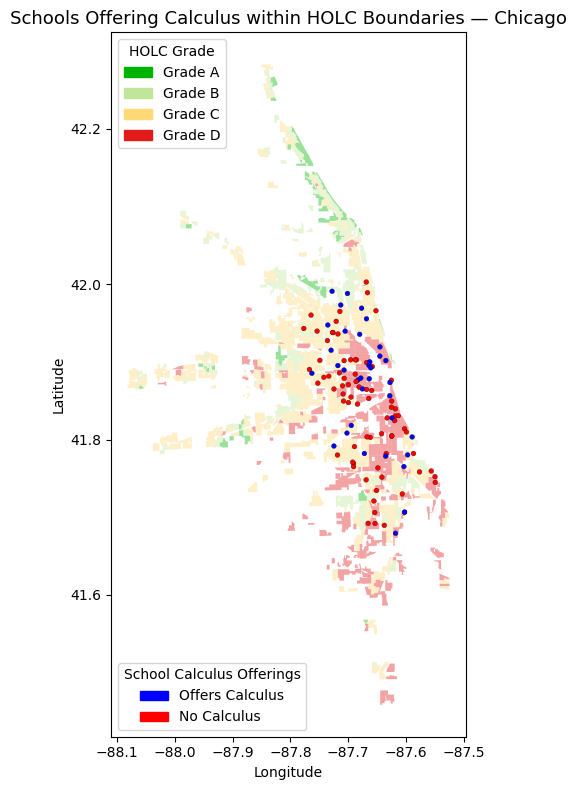

In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 1. Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)

# Clean up grade labels
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

# Define custom colors for grades (to match HOLC standard)
holc_colors = {
    "A": "#00b300",  # green
    "B": "#c2e699",  # light green
    "C": "#fed976",  # yellow
    "D": "#e31a1c"   # red
}

# === 2. Load your school CSV ===
schools_df = pd.read_csv("Calc_HS_Chicago.csv")

# === 3. Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === 4. Plot base map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each HOLC grade manually (for proper legend control)
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.4, label=f"HOLC {grade}")

# === 5. Plot schools ===
schools.plot(
    ax=ax,
    color=schools["Has_Calc"].map({"Yes": "blue", "No": "red"}),
    markersize=12,
    edgecolor="black",
    linewidth=0.2
)

# === 6. Create legends ===
# HOLC zone legend
holc_handles = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]

# School legend
school_handles = [
    mpatches.Patch(color='blue', label='Offers Calculus'),
    mpatches.Patch(color='red', label='No Calculus')
]

# Add both legends (place one manually below the other)
legend1 = ax.legend(handles=holc_handles, title="HOLC Grade", loc='upper left')
ax.add_artist(legend1)
legend2 = ax.legend(handles=school_handles, title="School Calculus Offerings", loc='lower left')

# === 7. Formatting ===
plt.title("Schools Offering Calculus within HOLC Boundaries — Chicago", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


## HOLC Map of Scools Offering All Classes

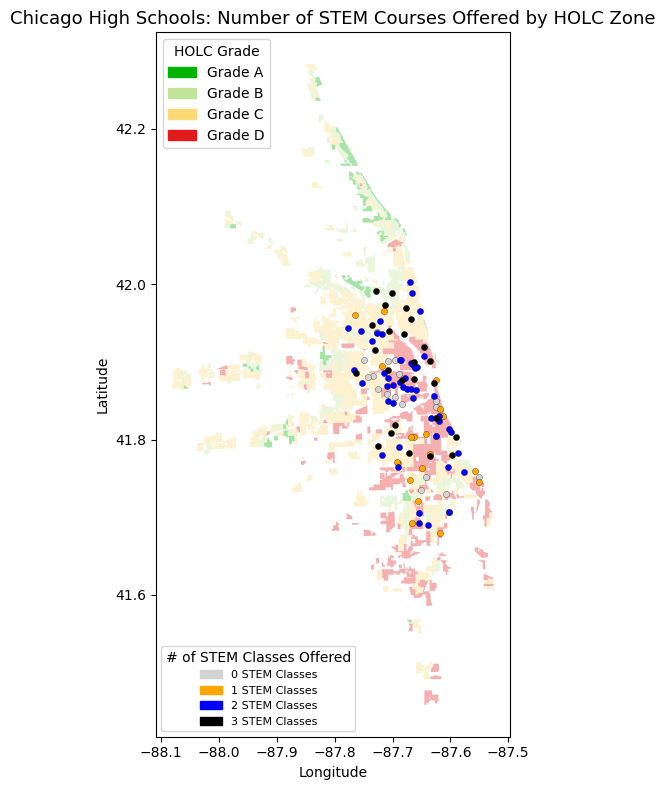

In [10]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

holc_colors = {
    "A": "#00b300",
    "B": "#c2e699",
    "C": "#fed976",
    "D": "#e31a1c"
}

# === Load merged dataset (with Has_Calc, Has_CS, Has_Physics) ===
schools_df = pd.read_csv("All_Classes_HS_Chicago.csv")

# === Create a numeric count variable for # of STEM classes offered ===
def count_stem_courses(row):
    return sum([
        row["Has_Calc"] == "Yes",
        row["Has_CS"] == "Yes",
        row["Has_Physics"] == "Yes"
    ])

schools_df["STEM_Count"] = schools_df.apply(count_stem_courses, axis=1)

# === Assign colors by number of courses ===
stem_colors = {
    0: "lightgray",   # No STEM courses
    1: "orange",      # 1 course
    2: "blue",        # 2 courses
    3: "black"        # 3 courses
}

# === Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot HOLC zones
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.35, label=f"HOLC {grade}")

# Plot schools by STEM count
for count, color in stem_colors.items():
    subset = schools[schools["STEM_Count"] == count]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            markersize=20,
            edgecolor="black",
            linewidths=0.2,
            label=f"{count} STEM Classes"
        )

# === Create legends ===
holc_legend = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]
stem_legend = [mpatches.Patch(color=color, label=f"{count} STEM Classes") for count, color in stem_colors.items()]

legend1 = ax.legend(handles=holc_legend, title="HOLC Grade", loc="upper left")
ax.add_artist(legend1)
ax.legend(handles=stem_legend, title="# of STEM Classes Offered", loc="lower left", fontsize=8)

# === Formatting ===
plt.title("Chicago High Schools: Number of STEM Courses Offered by HOLC Zone", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


# National Analysis

### Identify cities with enough HOLC districts

In [11]:
import geopandas as gpd
import pandas as pd
import os

# === 1. Load HOLC data ===
holc = gpd.read_file("mappinginequality.gpkg")

# === 2. Identify city and grade columns ===
city_col = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"

# === 3. Clean and normalize ===
holc = holc[[city_col, grade_col]].dropna(subset=[city_col, grade_col]).copy()
holc[city_col] = holc[city_col].str.strip()
holc[grade_col] = holc[grade_col].str.strip().str.upper()

# Keep only valid grades A–D
valid_grades = ["A", "B", "C", "D"]
holc = holc[holc[grade_col].isin(valid_grades)]

# === 4. Count number of each district grade per city ===
grade_counts = (
    holc.groupby([city_col, grade_col])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure all four grades appear as columns
for grade in valid_grades:
    if grade not in grade_counts.columns:
        grade_counts[grade] = 0

# === 5. Add total number of districts per city ===
grade_counts["Total_Districts"] = grade_counts[valid_grades].sum(axis=1)

# === 6. Sort alphabetically ===
grade_counts = grade_counts.sort_values(by=city_col).reset_index(drop=True)

# === 7. Print summary ===
print(f"\nNumber of HOLC cities analyzed: {len(grade_counts)}\n")
print(grade_counts.head(15).to_string(index=False))

# === 8. Save to CSV ===
#output_file = "HOLC_City_List.csv"
#grade_counts.to_csv(output_file, index=False)
#print(f"\n✅ Cleaned city HOLC grade counts saved to: {os.path.abspath(output_file)}")


# === Filter for cities with ≥ 3 of each HOLC grade (A–D) ===
valid_grades = ["A", "B", "C", "D"]
filter_mask = (grade_counts[valid_grades] >= 3).all(axis=1)
diverse_cities = grade_counts[filter_mask].copy()

# === Print results ===
print(f"\nNumber of cities with ≥ 3 of each grade (A–D): {len(diverse_cities)}\n")
print(diverse_cities.head(15).to_string(index=False))

# === (Optional) Save filtered cities ===
#diverse_cities.to_csv("holc_cities_with_3_each_grade.csv", index=False)
#print("✅ Filtered cities saved to 'holc_cities_with_3_each_grade.csv'")




Number of HOLC cities analyzed: 215

         city  A  B  C  D  Total_Districts
        Akron 11 19 24 13               67
       Albany  6  7  9  6               28
    Allentown  2  2  1  1                6
      Altoona  2 13 10  5               30
     Amarillo  3  2  6  9               20
    Arlington  3 10  4  0               17
    Asheville  3 10  4  4               21
      Atlanta  9 28 42 32              111
Atlantic City  2  7 15  3               27
      Augusta  1  9  8 12               30
       Aurora  2  5  6  9               22
       Austin  4  8  2  8               22
    Baltimore  6 22 22  9               59
 Battle Creek  3  8 17 11               39
     Bay City  1  3  5  8               17

Number of cities with ≥ 3 of each grade (A–D): 113

                    city  A  B  C  D  Total_Districts
                   Akron 11 19 24 13               67
                  Albany  6  7  9  6               28
               Asheville  3 10  4  4               21
     

### Imports national school and HOLC data and combines

- identifies national high schools in holc bounds
- merges with calc, phys, and cs data
- outputs csv with all this info

In [12]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Parameters and paths ===
holc_file = "mappinginequality.gpkg"
school_locations_file = "school-locations.csv"
buffer_meters = 402  # 0.25 miles
valid_grades = {"A", "B", "C", "D"}

crdc_base = os.path.join("2020-21-crdc-data", "CRDC", "School")
calc_file = os.path.join(crdc_base, "Calculus.csv")
cs_file   = os.path.join(crdc_base, "Computer Science.csv")
phys_file = os.path.join(crdc_base, "Physics.csv")

# === 2. Load HOLC and make buffers ===
holc = gpd.read_file(holc_file)
city_col  = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"
holc[city_col]  = holc[city_col].astype(str).str.strip()
holc[grade_col] = holc[grade_col].astype(str).str.strip().str.upper()

holc_3857 = holc.to_crs(epsg=3857)
holc_3857["buffer_geom"] = holc_3857.geometry.buffer(buffer_meters)

holc_buffers = gpd.GeoDataFrame(
    holc_3857[[city_col, grade_col]].copy(),
    geometry=holc_3857["buffer_geom"],
    crs="EPSG:3857"
)
holc_polys = holc_3857[[city_col, grade_col, "geometry"]].copy()

# === 3. Load and clean school data ===
schools = pd.read_csv(school_locations_file, dtype=str)
schools["LAT"] = pd.to_numeric(schools["LAT"], errors="coerce")
schools["LON"] = pd.to_numeric(schools["LON"], errors="coerce")
schools = schools.dropna(subset=["LAT", "LON"]).copy()

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LON"], schools["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# remove elementary / middle / early childhood
name_col = "NAME" if "NAME" in schools_gdf.columns else "SCH_NAME"
schools_gdf["NAME"] = schools_gdf[name_col].astype(str)
mask_not_hs = schools_gdf["NAME"].str.contains(
    "elem|elementary|middle|early childhood", case=False, na=False
)
schools_gdf = schools_gdf[~mask_not_hs].copy()
print(f"Remaining potential high schools: {len(schools_gdf)}")

# === 4. Schools within 0.25-mi buffers ===
holc_buffers = holc_buffers.to_crs(schools_gdf.crs)
schools_in_buffers = gpd.sjoin(
    schools_gdf, holc_buffers[[city_col, grade_col, "geometry"]],
    how="inner", predicate="intersects"
)
unique_ids = schools_in_buffers["NCESSCH"].unique().tolist()
schools_near = schools_gdf[schools_gdf["NCESSCH"].isin(unique_ids)].copy()
print(f"Schools within 0.25 mi of a HOLC area: {len(schools_near)}")

# === 5. Assign actual HOLC polygon; drop invalid grades ===
holc_polys = holc_polys.to_crs(schools_near.crs)
schools_assigned = gpd.sjoin(
    schools_near, holc_polys[[city_col, grade_col, "geometry"]],
    how="left", predicate="within"
)
schools_assigned["grade"] = schools_assigned["grade"].astype(str).str.upper().str.strip()
schools_assigned = schools_assigned[schools_assigned["grade"].isin(valid_grades)]
schools_assigned = schools_assigned.drop_duplicates(subset="NCESSCH")
schools_assigned = schools_assigned.to_crs(epsg=4326)
schools_assigned["LAT"] = schools_assigned.geometry.y
schools_assigned["LON"] = schools_assigned.geometry.x

holc_schools = schools_assigned[["NCESSCH", "NAME", "LAT", "LON", "grade"]].copy()
print(f"Schools with valid HOLC grades A–D: {len(holc_schools)}")

# === 6. Load Calculus CRDC data ===
calc = pd.read_csv(calc_file, dtype=str)
calc_col = next((c for c in calc.columns if "CALC" in c.upper()), None)
calc[calc_col] = pd.to_numeric(calc[calc_col], errors="coerce")
calc = calc[calc[calc_col] >= 0].copy()

# merge with HOLC to anchor high schools
merged = holc_schools.merge(
    calc[["COMBOKEY", calc_col]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)
merged["Num_Calc_Classes"] = merged[calc_col].astype(int)
merged["Has_Calc"] = merged["Num_Calc_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
calc_schools = merged[["NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Calc", "Num_Calc_Classes"]].copy()
print(f"Schools matched via Calculus data: {len(calc_schools)}")

# === 7. Load and merge Computer Science + Physics ===
def load_subset(path, substrs, ids):
    if not os.path.exists(path):
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df = pd.read_csv(path, dtype=str)
    col = next((c for c in df.columns for s in substrs if s.lower() in c.lower()), None)
    if col is None:
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df[col].notna() & (df[col] >= 0)]
    df = df[df["COMBOKEY"].isin(ids)].copy()
    return df[["COMBOKEY", col]].rename(columns={col: "count"})

ids = calc_schools["NCESSCH"].astype(str).tolist()
cs_df   = load_subset(cs_file,   ["CS", "COMPUTER"], ids)
phys_df = load_subset(phys_file, ["PHYS", "SCIENCECLASSES_PHYS"], ids)

# merge CS
calc_schools = calc_schools.merge(
    cs_df.rename(columns={"count": "Num_CS_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")
calc_schools["Num_CS_Classes"] = pd.to_numeric(calc_schools["Num_CS_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_CS"] = calc_schools["Num_CS_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# merge Physics
calc_schools = calc_schools.merge(
    phys_df.rename(columns={"count": "Num_Physics_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")
calc_schools["Num_Physics_Classes"] = pd.to_numeric(calc_schools["Num_Physics_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_Physics"] = calc_schools["Num_Physics_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# === 8. Save final national dataset ===
final_cols = [
    "NCESSCH", "NAME", "LAT", "LON", "grade",
    "Has_Calc", "Num_Calc_Classes",
    "Has_CS", "Num_CS_Classes",
    "Has_Physics", "Num_Physics_Classes"
]
national_final = calc_schools[final_cols].copy()

outfile = "National_Schools_with_AdvancedSTEM.csv"
national_final.to_csv(outfile, index=False)
print(f"\n✅ Saved national dataset to: {os.path.abspath(outfile)}")
print(f"✅ Total schools: {len(national_final)}")

print("\nPreview:")
print(national_final.head(10).to_string(index=False))


Remaining potential high schools: 55904
Schools within 0.25 mi of a HOLC area: 9165
Schools with valid HOLC grades A–D: 6435
Schools matched via Calculus data: 1767

✅ Saved national dataset to: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/National_Schools_with_AdvancedSTEM.csv
✅ Total schools: 1767

Preview:
     NCESSCH                                 NAME       LAT        LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
010039000165                   Parker High School 33.514596 -86.829301     D       No                 0     No               0         Yes                    7
010039000176                   Ramsay High School 33.497600 -86.798600     C      Yes                37     No               0         Yes                   28
010039000192                  Wenonah High School 33.454570 -86.884829     D      Yes                 1    Yes               4          No                    0
0

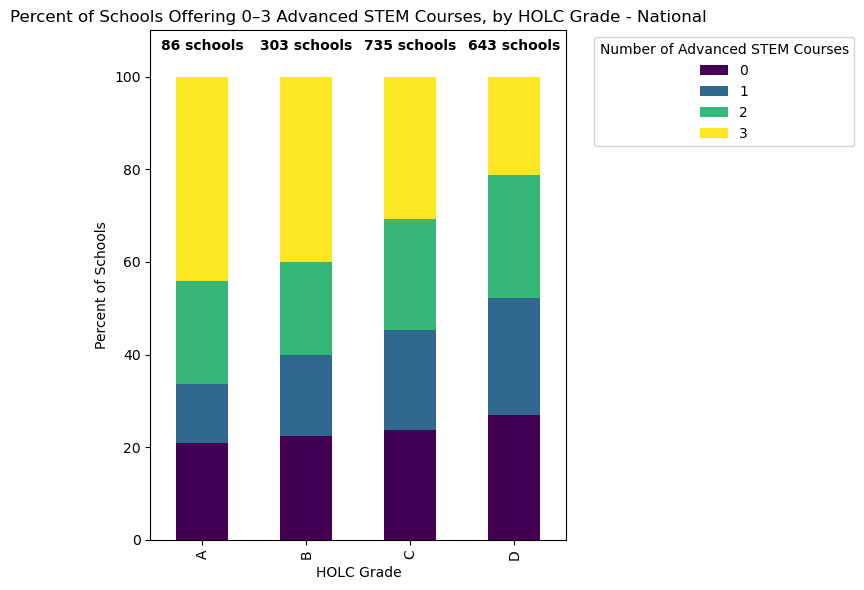

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - National ===
Course_Profile  Total_Schools    0  0_pct    1  1_pct    2  2_pct    3  3_pct
grade                                                                        
A                          86   18   20.9   11   12.8   19   22.1   38   44.2
B                         303   68   22.4   53   17.5   61   20.1  121   39.9
C                         735  175   23.8  158   21.5  176   23.9  226   30.7
D                         643  173   26.9  163   25.3  171   26.6  136   21.2


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("National_Schools_with_AdvancedSTEM.csv") 

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - National")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - National ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")

### Logistic Regression - Any Courses

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# === Load the national dataset ===
df = pd.read_csv("National_Schools_with_AdvancedSTEM.csv")

# --- Create binary indicator for any STEM course ---
df["Any_STEM"] = (
    (df["Has_Calc"] == "Yes") |
    (df["Has_CS"] == "Yes") |
    (df["Has_Physics"] == "Yes")
).astype(int)

# --- Clean HOLC grade as categorical with A as reference ---
df["grade"] = df["grade"].astype(str).str.strip().str.upper()
df = df[df["grade"].isin(["A", "B", "C", "D"])]

# --- Fit logistic regression ---
logit_model = smf.logit("Any_STEM ~ C(grade, Treatment(reference='A'))", data=df).fit()

# --- Display results ---
print(logit_model.summary())

# --- Optional: odds ratios ---
odds_ratios = pd.DataFrame({
    "term": logit_model.params.index,
    "odds_ratio": logit_model.params.apply(lambda x: round(np.exp(x), 3)),
    "p_value": logit_model.pvalues
})
print("\n=== Odds Ratios ===")
print(odds_ratios.to_string(index=False))


Optimization terminated successfully.
         Current function value: 0.556481
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Any_STEM   No. Observations:                 1767
Model:                          Logit   Df Residuals:                     1763
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                0.001765
Time:                        17:00:58   Log-Likelihood:                -983.30
converged:                       True   LL-Null:                       -985.04
Covariance Type:            nonrobust   LLR p-value:                    0.3238
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.3291

### Negative Binomial Regression - Num Courses

In [16]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Create count of total advanced STEM classes ---
df["Num_STEM_Total"] = (
    df["Num_Calc_Classes"].fillna(0).astype(int) +
    df["Num_CS_Classes"].fillna(0).astype(int) +
    df["Num_Physics_Classes"].fillna(0).astype(int)
)

# --- Fit Negative Binomial regression ---
nb_model = smf.glm(
    formula="Num_STEM_Total ~ C(grade, Treatment(reference='A'))",
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

# --- Display results ---
print(nb_model.summary())

# --- Exponentiated coefficients (rate ratios) ---
rate_ratios = pd.DataFrame({
    "term": nb_model.params.index,
    "exp_coef": np.exp(nb_model.params),
    "p_value": nb_model.pvalues
})
print("\n=== Incidence Rate Ratios (IRRs) ===")
print(rate_ratios.to_string(index=False))


                 Generalized Linear Model Regression Results                  
Dep. Variable:         Num_STEM_Total   No. Observations:                 1767
Model:                            GLM   Df Residuals:                     1763
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5862.2
Date:                Mon, 10 Nov 2025   Deviance:                       3444.7
Time:                        17:01:19   Pearson chi2:                 3.36e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04700
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## LA

In [18]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Load HOLC and school location data ===
holc_file = "mappinginequality.gpkg"
school_locations_file = "school-locations.csv"
buffer_meters = 402  # 0.25 miles
target_city = "los angeles"
valid_grades = {"A", "B", "C", "D"}

# --- Load HOLC ---
holc = gpd.read_file(holc_file)
city_col = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"
holc[city_col] = holc[city_col].astype(str).str.strip()
holc[grade_col] = holc[grade_col].astype(str).str.strip().str.upper()

holc_la = holc[holc[city_col].str.contains(target_city, case=False, na=False)].copy()
holc_la_3857 = holc_la.to_crs(epsg=3857)
holc_la_3857["buffer_geom"] = holc_la_3857.geometry.buffer(buffer_meters)

holc_buffers = gpd.GeoDataFrame(
    holc_la_3857[[city_col, grade_col]].copy(),
    geometry=holc_la_3857["buffer_geom"],
    crs="EPSG:3857"
)
holc_polys = holc_la_3857[[city_col, grade_col, "geometry"]].copy()

# --- Load school locations ---
schools = pd.read_csv(school_locations_file, dtype=str)
schools["LAT"] = pd.to_numeric(schools["LAT"], errors="coerce")
schools["LON"] = pd.to_numeric(schools["LON"], errors="coerce")
schools = schools.dropna(subset=["LAT", "LON"]).copy()

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LON"], schools["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# --- Remove clear non-high-schools ---
name_col = "NAME" if "NAME" in schools_gdf.columns else "SCH_NAME"
schools_gdf["NAME"] = schools_gdf[name_col].astype(str)
mask_not_hs = schools_gdf["NAME"].str.contains(
    "elem|elementary|middle|early childhood", case=False, na=False
)
schools_gdf = schools_gdf[~mask_not_hs].copy()

# --- Find schools within buffers ---
holc_buffers = holc_buffers.to_crs(schools_gdf.crs)
schools_in_buffers = gpd.sjoin(
    schools_gdf, holc_buffers[[city_col, grade_col, "geometry"]],
    how="inner", predicate="intersects"
)
schools_near = schools_gdf[schools_gdf["NCESSCH"].isin(schools_in_buffers["NCESSCH"])].copy()

# --- Assign HOLC polygons (A–D only) ---
holc_polys = holc_polys.to_crs(schools_near.crs)
schools_assigned = gpd.sjoin(
    schools_near, holc_polys[[city_col, grade_col, "geometry"]],
    how="left", predicate="within"
)
schools_assigned["grade"] = schools_assigned["grade"].astype(str).str.upper().str.strip()
schools_assigned = schools_assigned[schools_assigned["grade"].isin(valid_grades)].drop_duplicates(subset="NCESSCH")

schools_assigned = schools_assigned.to_crs(epsg=4326)
schools_assigned["LAT"] = schools_assigned.geometry.y
schools_assigned["LON"] = schools_assigned.geometry.x

holc_schools = schools_assigned[["NCESSCH", "NAME", "LAT", "LON", "grade"]].copy()

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
calc_col = None
for c in calc.columns:
    if "CALC" in c.upper():
        calc_col = c
        break
calc[calc_col] = pd.to_numeric(calc[calc_col], errors="coerce")
calc = calc[calc[calc_col] >= 0].copy()

# --- Merge HOLC + Calculus ---
merged = holc_schools.merge(
    calc[["COMBOKEY", calc_col]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)
merged["Num_Calc_Classes"] = merged[calc_col].astype(int)
merged["Has_Calc"] = merged["Num_Calc_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
calc_schools = merged[["NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Calc", "Num_Calc_Classes"]].copy()
print(f"✅ Schools matched via Calculus data: {len(calc_schools)}")

# === 3. Load and merge Computer Science + Physics for these same schools ===
crdc_base = os.path.join("2020-21-crdc-data", "CRDC", "School")
cs_file   = os.path.join(crdc_base, "Computer Science.csv")
phys_file = os.path.join(crdc_base, "Physics.csv")

def load_crdc_subset(path, substrs, key_list):
    if not os.path.exists(path):
        print(f"⚠️ File missing: {path}")
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df = pd.read_csv(path, dtype=str)
    col = None
    for s in substrs:
        for c in df.columns:
            if s.lower() in c.lower():
                col = c
                break
        if col: break
    if col is None:
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df[col].notna() & (df[col] >= 0)]
    df = df[df["COMBOKEY"].isin(key_list)].copy()
    return df[["COMBOKEY", col]].rename(columns={col: "count"})

school_ids = calc_schools["NCESSCH"].astype(str).tolist()
cs_df   = load_crdc_subset(cs_file, ["CS", "COMPUTER"], school_ids)
phys_df = load_crdc_subset(phys_file, ["PHYS", "SCIENCECLASSES_PHYS"], school_ids)

# --- Merge CS ---
calc_schools = calc_schools.merge(
    cs_df.rename(columns={"count": "Num_CS_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_CS_Classes"] = pd.to_numeric(calc_schools["Num_CS_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_CS"] = calc_schools["Num_CS_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# --- Merge Physics ---
calc_schools = calc_schools.merge(
    phys_df.rename(columns={"count": "Num_Physics_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_Physics_Classes"] = pd.to_numeric(calc_schools["Num_Physics_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_Physics"] = calc_schools["Num_Physics_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# === 4. Save Final Dataset ===
final_cols = [
    "NCESSCH", "NAME", "LAT", "LON", "grade",
    "Has_Calc", "Num_Calc_Classes",
    "Has_CS", "Num_CS_Classes",
    "Has_Physics", "Num_Physics_Classes"
]
la_final = calc_schools[final_cols].copy()

output_file = "LA_Schools_with_AdvancedSTEM.csv"
la_final.to_csv(output_file, index=False)
print(f"✅ Final LA dataset saved: {os.path.abspath(output_file)}")
print(f"✅ Schools in final file: {len(la_final)}")

# === Preview ===
print("\nPreview:")
print(la_final.head(10).to_string(index=False))


✅ Schools matched via Calculus data: 163
✅ Final LA dataset saved: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/LA_Schools_with_AdvancedSTEM.csv
✅ Schools in final file: 163

Preview:
     NCESSCH                                                NAME       LAT         LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
060015310929                                       Alhambra High 34.092900 -118.128800     C      Yes                 4    Yes               2         Yes                   14
060015310932                     Independence High (Alternative) 34.090661 -118.141227     C       No                 0     No               0          No                    0
060148804593                              Palisades Charter High 34.047871 -118.531105     B      Yes                 4    Yes               3         Yes                    5
060149410517                      Los Angeles Leadership Academy

### LA Map

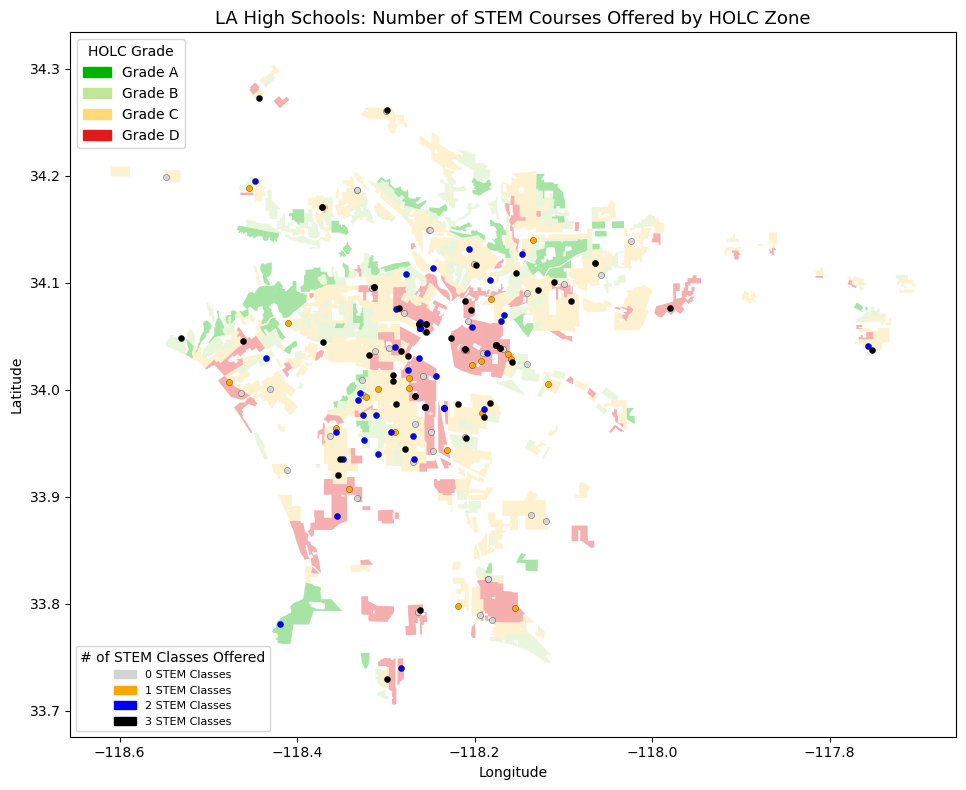

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Los Angeles", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

holc_colors = {
    "A": "#00b300",
    "B": "#c2e699",
    "C": "#fed976",
    "D": "#e31a1c"
}

# === Load merged dataset (with Has_Calc, Has_CS, Has_Physics) ===
schools_df = pd.read_csv("LA_Schools_with_AdvancedSTEM.csv")

# === Create a numeric count variable for # of STEM classes offered ===
def count_stem_courses(row):
    return sum([
        row["Has_Calc"] == "Yes",
        row["Has_CS"] == "Yes",
        row["Has_Physics"] == "Yes"
    ])

schools_df["STEM_Count"] = schools_df.apply(count_stem_courses, axis=1)

# === Assign colors by number of courses ===
stem_colors = {
    0: "lightgray",   # No STEM courses
    1: "orange",      # 1 course
    2: "blue",        # 2 courses
    3: "black"        # 3 courses
}

# === Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot HOLC zones
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.35, label=f"HOLC {grade}")

# Plot schools by STEM count
for count, color in stem_colors.items():
    subset = schools[schools["STEM_Count"] == count]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            markersize=20,
            edgecolor="black",
            linewidths=0.2,
            label=f"{count} STEM Classes"
        )

# === Create legends ===
holc_legend = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]
stem_legend = [mpatches.Patch(color=color, label=f"{count} STEM Classes") for count, color in stem_colors.items()]

legend1 = ax.legend(handles=holc_legend, title="HOLC Grade", loc="upper left")
ax.add_artist(legend1)
ax.legend(handles=stem_legend, title="# of STEM Classes Offered", loc="lower left", fontsize=8)

# === Formatting ===
plt.title("LA High Schools: Number of STEM Courses Offered by HOLC Zone", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### LA % Bar Chart

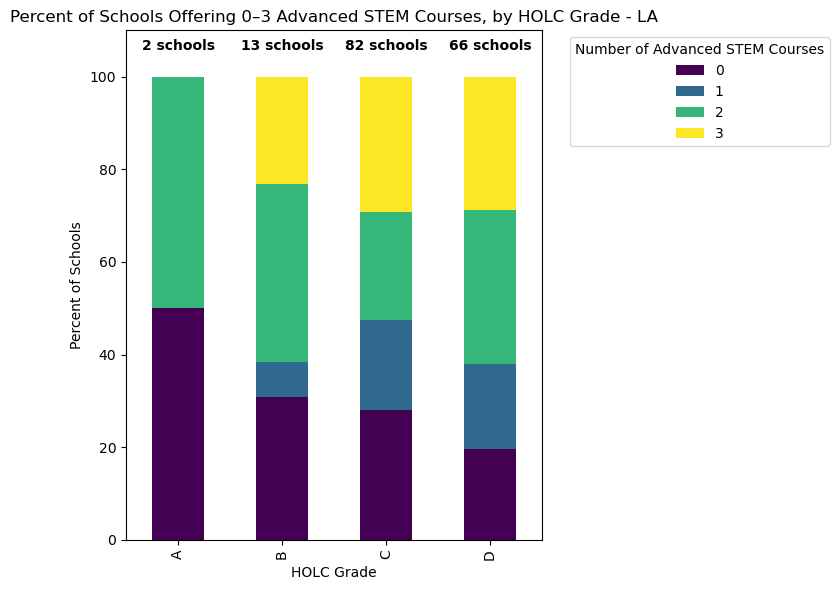

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - LA ===
Course_Profile  Total_Schools   0  0_pct   1  1_pct   2  2_pct   3  3_pct
grade                                                                    
A                           2   1   50.0   0    0.0   1   50.0   0    0.0
B                          13   4   30.8   1    7.7   5   38.5   3   23.1
C                          82  23   28.0  16   19.5  19   23.2  24   29.3
D                          66  13   19.7  12   18.2  22   33.3  19   28.8


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("LA_Schools_with_AdvancedSTEM.csv") 

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - LA")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - LA ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")

## Detroit

In [19]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Load HOLC and school location data ===
holc_file = "mappinginequality.gpkg"
school_locations_file = "school-locations.csv"
buffer_meters = 402  # 0.25 miles
target_city = "detroit"
valid_grades = {"A", "B", "C", "D"}

# --- Load HOLC ---
holc = gpd.read_file(holc_file)
city_col = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"
holc[city_col] = holc[city_col].astype(str).str.strip()
holc[grade_col] = holc[grade_col].astype(str).str.strip().str.upper()

holc_la = holc[holc[city_col].str.contains(target_city, case=False, na=False)].copy()
holc_la_3857 = holc_la.to_crs(epsg=3857)
holc_la_3857["buffer_geom"] = holc_la_3857.geometry.buffer(buffer_meters)

holc_buffers = gpd.GeoDataFrame(
    holc_la_3857[[city_col, grade_col]].copy(),
    geometry=holc_la_3857["buffer_geom"],
    crs="EPSG:3857"
)
holc_polys = holc_la_3857[[city_col, grade_col, "geometry"]].copy()

# --- Load school locations ---
schools = pd.read_csv(school_locations_file, dtype=str)
schools["LAT"] = pd.to_numeric(schools["LAT"], errors="coerce")
schools["LON"] = pd.to_numeric(schools["LON"], errors="coerce")
schools = schools.dropna(subset=["LAT", "LON"]).copy()

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LON"], schools["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# --- Remove clear non-high-schools ---
name_col = "NAME" if "NAME" in schools_gdf.columns else "SCH_NAME"
schools_gdf["NAME"] = schools_gdf[name_col].astype(str)
mask_not_hs = schools_gdf["NAME"].str.contains(
    "elem|elementary|middle|early childhood", case=False, na=False
)
schools_gdf = schools_gdf[~mask_not_hs].copy()

# --- Find schools within buffers ---
holc_buffers = holc_buffers.to_crs(schools_gdf.crs)
schools_in_buffers = gpd.sjoin(
    schools_gdf, holc_buffers[[city_col, grade_col, "geometry"]],
    how="inner", predicate="intersects"
)
schools_near = schools_gdf[schools_gdf["NCESSCH"].isin(schools_in_buffers["NCESSCH"])].copy()

# --- Assign HOLC polygons (A–D only) ---
holc_polys = holc_polys.to_crs(schools_near.crs)
schools_assigned = gpd.sjoin(
    schools_near, holc_polys[[city_col, grade_col, "geometry"]],
    how="left", predicate="within"
)
schools_assigned["grade"] = schools_assigned["grade"].astype(str).str.upper().str.strip()
schools_assigned = schools_assigned[schools_assigned["grade"].isin(valid_grades)].drop_duplicates(subset="NCESSCH")

schools_assigned = schools_assigned.to_crs(epsg=4326)
schools_assigned["LAT"] = schools_assigned.geometry.y
schools_assigned["LON"] = schools_assigned.geometry.x

holc_schools = schools_assigned[["NCESSCH", "NAME", "LAT", "LON", "grade"]].copy()

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
calc_col = None
for c in calc.columns:
    if "CALC" in c.upper():
        calc_col = c
        break
calc[calc_col] = pd.to_numeric(calc[calc_col], errors="coerce")
calc = calc[calc[calc_col] >= 0].copy()

# --- Merge HOLC + Calculus ---
merged = holc_schools.merge(
    calc[["COMBOKEY", calc_col]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)
merged["Num_Calc_Classes"] = merged[calc_col].astype(int)
merged["Has_Calc"] = merged["Num_Calc_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
calc_schools = merged[["NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Calc", "Num_Calc_Classes"]].copy()
print(f"✅ Schools matched via Calculus data: {len(calc_schools)}")

# === 3. Load and merge Computer Science + Physics for these same schools ===
crdc_base = os.path.join("2020-21-crdc-data", "CRDC", "School")
cs_file   = os.path.join(crdc_base, "Computer Science.csv")
phys_file = os.path.join(crdc_base, "Physics.csv")

def load_crdc_subset(path, substrs, key_list):
    if not os.path.exists(path):
        print(f"⚠️ File missing: {path}")
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df = pd.read_csv(path, dtype=str)
    col = None
    for s in substrs:
        for c in df.columns:
            if s.lower() in c.lower():
                col = c
                break
        if col: break
    if col is None:
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df[col].notna() & (df[col] >= 0)]
    df = df[df["COMBOKEY"].isin(key_list)].copy()
    return df[["COMBOKEY", col]].rename(columns={col: "count"})

school_ids = calc_schools["NCESSCH"].astype(str).tolist()
cs_df   = load_crdc_subset(cs_file, ["CS", "COMPUTER"], school_ids)
phys_df = load_crdc_subset(phys_file, ["PHYS", "SCIENCECLASSES_PHYS"], school_ids)

# --- Merge CS ---
calc_schools = calc_schools.merge(
    cs_df.rename(columns={"count": "Num_CS_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_CS_Classes"] = pd.to_numeric(calc_schools["Num_CS_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_CS"] = calc_schools["Num_CS_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# --- Merge Physics ---
calc_schools = calc_schools.merge(
    phys_df.rename(columns={"count": "Num_Physics_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_Physics_Classes"] = pd.to_numeric(calc_schools["Num_Physics_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_Physics"] = calc_schools["Num_Physics_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# === 4. Save Final Dataset ===
final_cols = [
    "NCESSCH", "NAME", "LAT", "LON", "grade",
    "Has_Calc", "Num_Calc_Classes",
    "Has_CS", "Num_CS_Classes",
    "Has_Physics", "Num_Physics_Classes"
]
la_final = calc_schools[final_cols].copy()

output_file = "Detroit_Schools_with_AdvancedSTEM.csv"
la_final.to_csv(output_file, index=False)
print(f"✅ Final LA dataset saved: {os.path.abspath(output_file)}")
print(f"✅ Schools in final file: {len(la_final)}")

# === Preview ===
print("\nPreview:")
print(la_final.head(10).to_string(index=False))


✅ Schools matched via Calculus data: 85
✅ Final LA dataset saved: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/Detroit_Schools_with_AdvancedSTEM.csv
✅ Schools in final file: 85

Preview:
     NCESSCH                                              NAME       LAT        LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
260001500767                  WayneWestland Innovative Academy 42.269214 -83.378459     C       No                 0     No               0         Yes                    2
260013901488                          Cesar Chavez High School 42.312100 -83.114300     D      Yes                 2     No               0         Yes                    1
260016601035   Academy for Business and Technology High School 42.274600 -83.196700     C       No                 0     No               0         Yes                    4
260017001039            Detroit Community Schools  High School 42.380305 

### Detroit Map

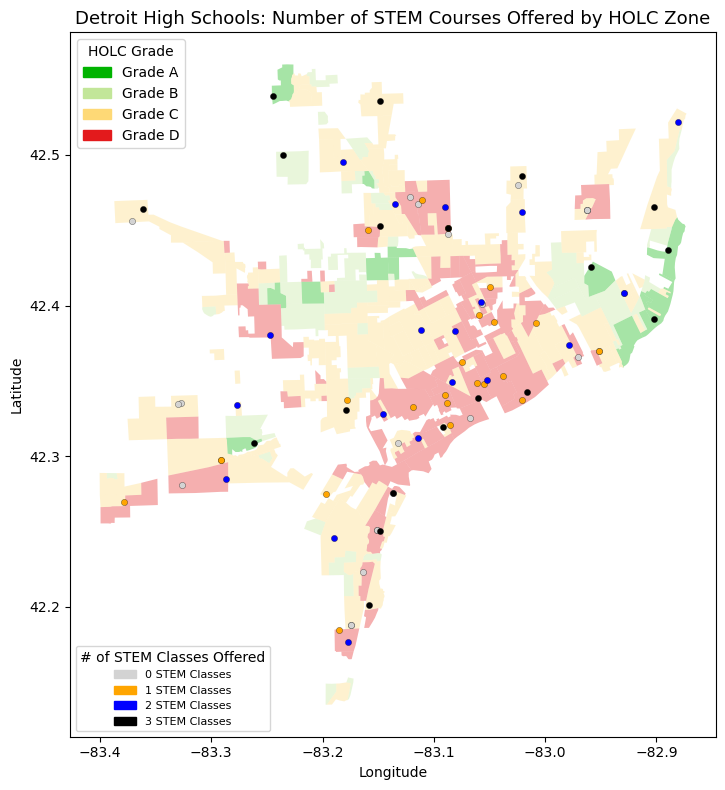

In [22]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Detroit", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

holc_colors = {
    "A": "#00b300",
    "B": "#c2e699",
    "C": "#fed976",
    "D": "#e31a1c"
}

# === Load merged dataset (with Has_Calc, Has_CS, Has_Physics) ===
schools_df = pd.read_csv("Detroit_Schools_with_AdvancedSTEM.csv")

# === Create a numeric count variable for # of STEM classes offered ===
def count_stem_courses(row):
    return sum([
        row["Has_Calc"] == "Yes",
        row["Has_CS"] == "Yes",
        row["Has_Physics"] == "Yes"
    ])

schools_df["STEM_Count"] = schools_df.apply(count_stem_courses, axis=1)

# === Assign colors by number of courses ===
stem_colors = {
    0: "lightgray",   # No STEM courses
    1: "orange",      # 1 course
    2: "blue",        # 2 courses
    3: "black"        # 3 courses
}

# === Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot HOLC zones
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.35, label=f"HOLC {grade}")

# Plot schools by STEM count
for count, color in stem_colors.items():
    subset = schools[schools["STEM_Count"] == count]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            markersize=20,
            edgecolor="black",
            linewidths=0.2,
            label=f"{count} STEM Classes"
        )

# === Create legends ===
holc_legend = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]
stem_legend = [mpatches.Patch(color=color, label=f"{count} STEM Classes") for count, color in stem_colors.items()]

legend1 = ax.legend(handles=holc_legend, title="HOLC Grade", loc="upper left")
ax.add_artist(legend1)
ax.legend(handles=stem_legend, title="# of STEM Classes Offered", loc="lower left", fontsize=8)

# === Formatting ===
plt.title("Detroit High Schools: Number of STEM Courses Offered by HOLC Zone", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Detroit % Bar Chart

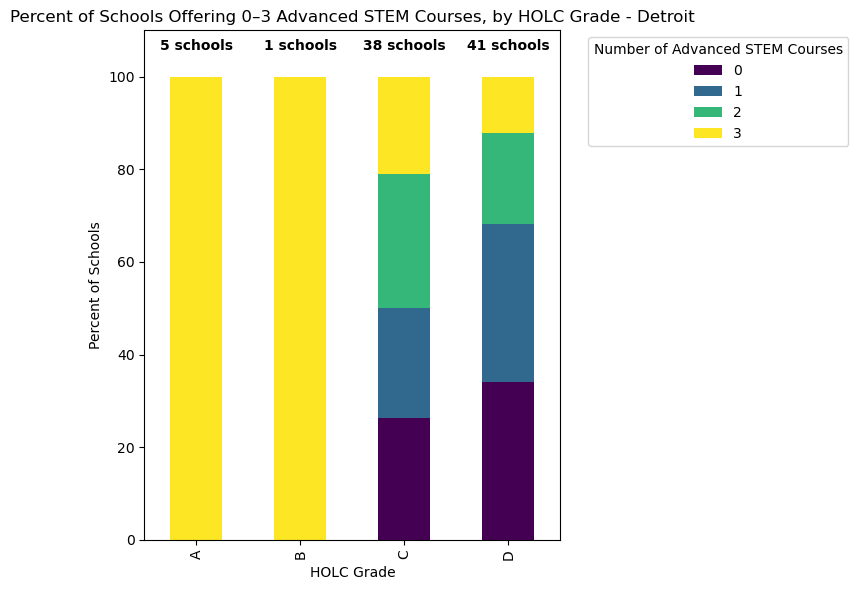

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Detroit ===
Course_Profile  Total_Schools   0  0_pct   1  1_pct   2  2_pct  3  3_pct
grade                                                                   
A                           5   0    0.0   0    0.0   0    0.0  5  100.0
B                           1   0    0.0   0    0.0   0    0.0  1  100.0
C                          38  10   26.3   9   23.7  11   28.9  8   21.1
D                          41  14   34.1  14   34.1   8   19.5  5   12.2


In [27]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("Detroit_Schools_with_AdvancedSTEM.csv") 

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Detroit")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Detroit ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")

## Philly

In [20]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Load HOLC and school location data ===
holc_file = "mappinginequality.gpkg"
school_locations_file = "school-locations.csv"
buffer_meters = 402  # 0.25 miles
target_city = "philadelphia"
valid_grades = {"A", "B", "C", "D"}

# --- Load HOLC ---
holc = gpd.read_file(holc_file)
city_col = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"
holc[city_col] = holc[city_col].astype(str).str.strip()
holc[grade_col] = holc[grade_col].astype(str).str.strip().str.upper()

holc_la = holc[holc[city_col].str.contains(target_city, case=False, na=False)].copy()
holc_la_3857 = holc_la.to_crs(epsg=3857)
holc_la_3857["buffer_geom"] = holc_la_3857.geometry.buffer(buffer_meters)

holc_buffers = gpd.GeoDataFrame(
    holc_la_3857[[city_col, grade_col]].copy(),
    geometry=holc_la_3857["buffer_geom"],
    crs="EPSG:3857"
)
holc_polys = holc_la_3857[[city_col, grade_col, "geometry"]].copy()

# --- Load school locations ---
schools = pd.read_csv(school_locations_file, dtype=str)
schools["LAT"] = pd.to_numeric(schools["LAT"], errors="coerce")
schools["LON"] = pd.to_numeric(schools["LON"], errors="coerce")
schools = schools.dropna(subset=["LAT", "LON"]).copy()

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LON"], schools["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# --- Remove clear non-high-schools ---
name_col = "NAME" if "NAME" in schools_gdf.columns else "SCH_NAME"
schools_gdf["NAME"] = schools_gdf[name_col].astype(str)
mask_not_hs = schools_gdf["NAME"].str.contains(
    "elem|elementary|middle|early childhood", case=False, na=False
)
schools_gdf = schools_gdf[~mask_not_hs].copy()

# --- Find schools within buffers ---
holc_buffers = holc_buffers.to_crs(schools_gdf.crs)
schools_in_buffers = gpd.sjoin(
    schools_gdf, holc_buffers[[city_col, grade_col, "geometry"]],
    how="inner", predicate="intersects"
)
schools_near = schools_gdf[schools_gdf["NCESSCH"].isin(schools_in_buffers["NCESSCH"])].copy()

# --- Assign HOLC polygons (A–D only) ---
holc_polys = holc_polys.to_crs(schools_near.crs)
schools_assigned = gpd.sjoin(
    schools_near, holc_polys[[city_col, grade_col, "geometry"]],
    how="left", predicate="within"
)
schools_assigned["grade"] = schools_assigned["grade"].astype(str).str.upper().str.strip()
schools_assigned = schools_assigned[schools_assigned["grade"].isin(valid_grades)].drop_duplicates(subset="NCESSCH")

schools_assigned = schools_assigned.to_crs(epsg=4326)
schools_assigned["LAT"] = schools_assigned.geometry.y
schools_assigned["LON"] = schools_assigned.geometry.x

holc_schools = schools_assigned[["NCESSCH", "NAME", "LAT", "LON", "grade"]].copy()

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
calc_col = None
for c in calc.columns:
    if "CALC" in c.upper():
        calc_col = c
        break
calc[calc_col] = pd.to_numeric(calc[calc_col], errors="coerce")
calc = calc[calc[calc_col] >= 0].copy()

# --- Merge HOLC + Calculus ---
merged = holc_schools.merge(
    calc[["COMBOKEY", calc_col]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)
merged["Num_Calc_Classes"] = merged[calc_col].astype(int)
merged["Has_Calc"] = merged["Num_Calc_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
calc_schools = merged[["NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Calc", "Num_Calc_Classes"]].copy()
print(f"✅ Schools matched via Calculus data: {len(calc_schools)}")

# === 3. Load and merge Computer Science + Physics for these same schools ===
crdc_base = os.path.join("2020-21-crdc-data", "CRDC", "School")
cs_file   = os.path.join(crdc_base, "Computer Science.csv")
phys_file = os.path.join(crdc_base, "Physics.csv")

def load_crdc_subset(path, substrs, key_list):
    if not os.path.exists(path):
        print(f"⚠️ File missing: {path}")
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df = pd.read_csv(path, dtype=str)
    col = None
    for s in substrs:
        for c in df.columns:
            if s.lower() in c.lower():
                col = c
                break
        if col: break
    if col is None:
        return pd.DataFrame(columns=["COMBOKEY", "count"])
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df[col].notna() & (df[col] >= 0)]
    df = df[df["COMBOKEY"].isin(key_list)].copy()
    return df[["COMBOKEY", col]].rename(columns={col: "count"})

school_ids = calc_schools["NCESSCH"].astype(str).tolist()
cs_df   = load_crdc_subset(cs_file, ["CS", "COMPUTER"], school_ids)
phys_df = load_crdc_subset(phys_file, ["PHYS", "SCIENCECLASSES_PHYS"], school_ids)

# --- Merge CS ---
calc_schools = calc_schools.merge(
    cs_df.rename(columns={"count": "Num_CS_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_CS_Classes"] = pd.to_numeric(calc_schools["Num_CS_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_CS"] = calc_schools["Num_CS_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# --- Merge Physics ---
calc_schools = calc_schools.merge(
    phys_df.rename(columns={"count": "Num_Physics_Classes"}),
    left_on="NCESSCH", right_on="COMBOKEY", how="left"
).drop(columns=["COMBOKEY"], errors="ignore")

calc_schools["Num_Physics_Classes"] = pd.to_numeric(calc_schools["Num_Physics_Classes"], errors="coerce").fillna(0).astype(int)
calc_schools["Has_Physics"] = calc_schools["Num_Physics_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# === 4. Save Final Dataset ===
final_cols = [
    "NCESSCH", "NAME", "LAT", "LON", "grade",
    "Has_Calc", "Num_Calc_Classes",
    "Has_CS", "Num_CS_Classes",
    "Has_Physics", "Num_Physics_Classes"
]
la_final = calc_schools[final_cols].copy()

output_file = "Philly_Schools_with_AdvancedSTEM.csv"
la_final.to_csv(output_file, index=False)
print(f"✅ Final LA dataset saved: {os.path.abspath(output_file)}")
print(f"✅ Schools in final file: {len(la_final)}")

# === Preview ===
print("\nPreview:")
print(la_final.head(10).to_string(index=False))


✅ Schools matched via Calculus data: 65
✅ Final LA dataset saved: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/Philly_Schools_with_AdvancedSTEM.csv
✅ Schools in final file: 65

Preview:
     NCESSCH                                                   NAME       LAT        LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
420001300318                   Community Academy of Philadelphia CS 40.004500 -75.106700     C      Yes                 1    Yes               1         Yes                    1
420003600391 Preparatory CS of Mathematics Science Tech and Careers 39.928500 -75.186800     D       No                 0    Yes              22          No                    0
420003800393                                  Imhotep Institute CHS 40.049300 -75.154900     C      Yes                 1     No               0         Yes                    4
420004000399                               Multicultur

### Philly Map

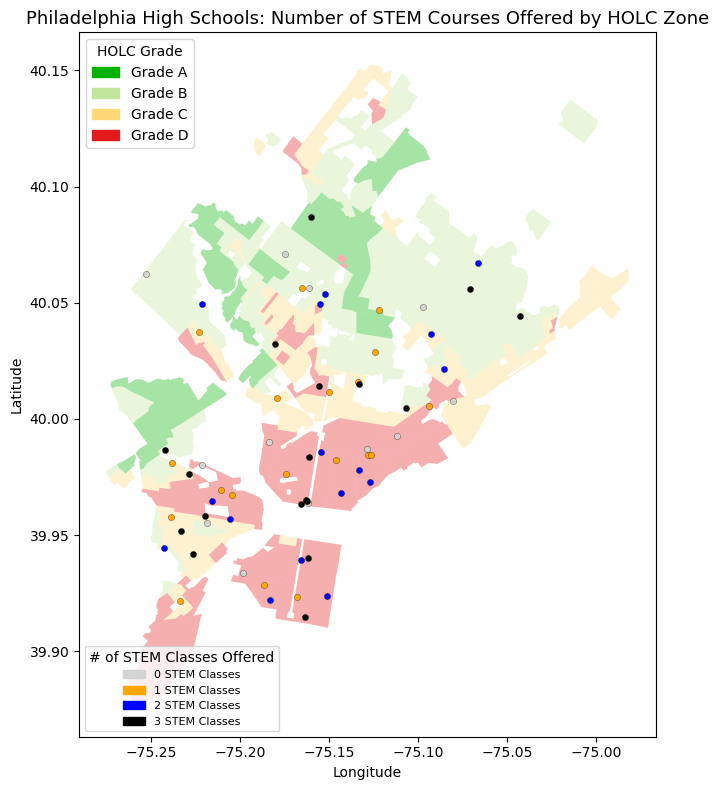

In [23]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Philadelphia", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

holc_colors = {
    "A": "#00b300",
    "B": "#c2e699",
    "C": "#fed976",
    "D": "#e31a1c"
}

# === Load merged dataset (with Has_Calc, Has_CS, Has_Physics) ===
schools_df = pd.read_csv("Philly_Schools_with_AdvancedSTEM.csv")

# === Create a numeric count variable for # of STEM classes offered ===
def count_stem_courses(row):
    return sum([
        row["Has_Calc"] == "Yes",
        row["Has_CS"] == "Yes",
        row["Has_Physics"] == "Yes"
    ])

schools_df["STEM_Count"] = schools_df.apply(count_stem_courses, axis=1)

# === Assign colors by number of courses ===
stem_colors = {
    0: "lightgray",   # No STEM courses
    1: "orange",      # 1 course
    2: "blue",        # 2 courses
    3: "black"        # 3 courses
}

# === Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot HOLC zones
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.35, label=f"HOLC {grade}")

# Plot schools by STEM count
for count, color in stem_colors.items():
    subset = schools[schools["STEM_Count"] == count]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            markersize=20,
            edgecolor="black",
            linewidths=0.2,
            label=f"{count} STEM Classes"
        )

# === Create legends ===
holc_legend = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]
stem_legend = [mpatches.Patch(color=color, label=f"{count} STEM Classes") for count, color in stem_colors.items()]

legend1 = ax.legend(handles=holc_legend, title="HOLC Grade", loc="upper left")
ax.add_artist(legend1)
ax.legend(handles=stem_legend, title="# of STEM Classes Offered", loc="lower left", fontsize=8)

# === Formatting ===
plt.title("Philadelphia High Schools: Number of STEM Courses Offered by HOLC Zone", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Philly % Bar Chart

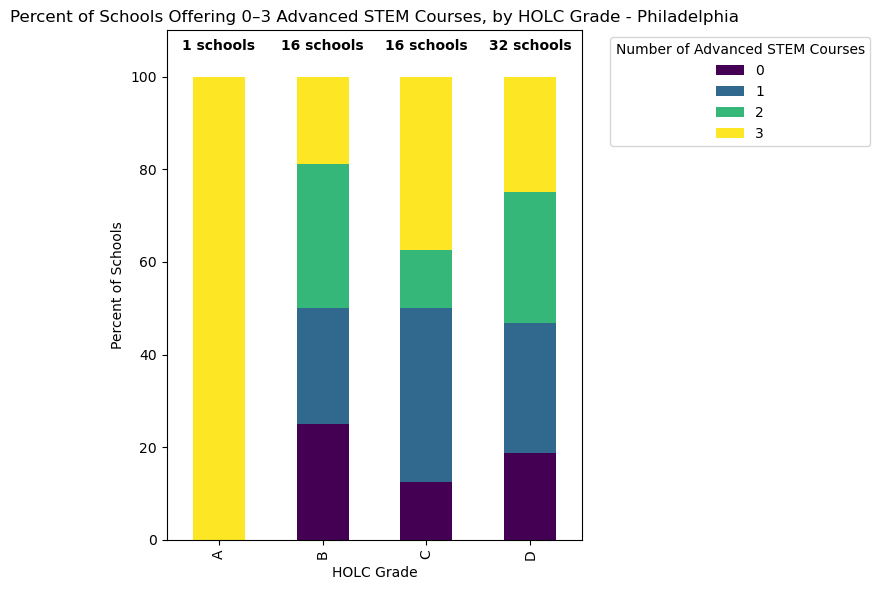

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Philadelphia ===
Course_Profile  Total_Schools  0  0_pct  1  1_pct  2  2_pct  3  3_pct
grade                                                                
A                           1  0    0.0  0    0.0  0    0.0  1  100.0
B                          16  4   25.0  4   25.0  5   31.2  3   18.8
C                          16  2   12.5  6   37.5  2   12.5  6   37.5
D                          32  6   18.8  9   28.1  9   28.1  8   25.0


In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("Philly_Schools_with_AdvancedSTEM.csv") 

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Philadelphia")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade - Philadelphia ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")